In [21]:
"""
GP emulation
"""
##### Packages ###############
import numpy as np  
import matplotlib.pylab as plt
import time
import pickle
import os
from sklearn.decomposition import PCA
# import GPy
import matplotlib.ticker as ticker
import gpflow


In [22]:
############################# PARAMETERS ##############################

dataDir = "./Data/" ## Data folder
modelDir = "./Models/" ## Data folder
plotsDir = "./Plots/" ## Data folder

nRankMax = [2, 4, 8, 12, 16, 32][4]  ## Number of basis vectors in truncated PCA
## Increasing nRankMax will increase emulation precision (asymptotically), but reduce the speed

# del_idx = [5, 25, 4, 42]  ## Random holdouts (not used in training, reserved for validation) 
# del_idx = [11, 17, 20, 37, 46]  ## Random holdouts (not used in training, reserved for validation) 
# del_idx = [11, 5, 4, 42]  ## Random holdouts (not used in training, reserved for validation) 
del_idx = []  ## Random holdouts (not used in training, reserved for validation) 

# 11, 17, 20, 37, 46, 
# DONOT use these: (array([22, 15, 19, 20, 35]), array([27, 34, 30, 29, 14])) -- edge cases
snap_ID = 47


############################# PARAMETERS ##############################

dataDir = "./Data/Emulator213bins/" ## Data folder
fileIn = dataDir + 'ratiosbins_' + str(snap_ID) + '.txt'



paramIn = dataDir + 'mg.design'
# fileIn = dataDir + ['ratios.txt', 'PMG.txt'][0]



# plotsDir = "./Plots/" ## Data folder
# dataDir = "./Data/Emulator_data/" ## Data folder
# dataDir = "./Data/Emulator213bins/" ## Data folder

# paramIn = dataDir + 'mg.design'  ## parameter file



az = np.loadtxt(dataDir + 'timestepsCOLA.txt', skiprows=1) 
fileIn = dataDir + 'ratiosbins_' + str(snap_ID) + '.txt'
### GPmodel = modelDir + 'a89003GPflow_model_213Smooth_rank' + str(nRankMax) + 'snap' + str(snap_ID)  ## Double and single quotes are necessary
# GPmodel = modelDir + 'a89004GPflow_model_213Smooth_rank' + str(nRankMax) + 'snap' + str(snap_ID)  ## Double and single quotes are necessary
# GPmodel = modelDir + '118GP_smooth_rank' + str(nRankMax) + 'snap' + str(snap_ID)  ## Double and single quotes are necessary
# PCAmodel = modelDir + '118PCA_smooth_rank' + str(nRankMax) + 'snap' + str(snap_ID)  ## Double and single quotes are necessary

# print(GPmodel)
################################# I/O #################################


In [23]:
loadFile = np.loadtxt(fileIn)
PmPl_all = loadFile[:, 1:].T
kvals = loadFile[:,0]


parameter_array_all = np.loadtxt(paramIn)


# ############## rescaling ##############


# def rescale01(f):
#     return np.min(f), np.max(f), (f - np.min(f)) / (np.max(f) - np.min(f))


# lhd = np.zeros_like(parameter_array_all)
# for i in range(parameter_array_all.shape[1]):
#     _, _, lhd[:, i] = rescale01(parameter_array_all[:, i])
   

# parameter_array_all = lhd

# # _,_,PmPl_all = rescale01(loadFile[:, 1:].T)









############## rescaling ##############


def rescale01(f):
    return np.min(f), np.max(f), (f - np.min(f)) / (np.max(f) - np.min(f))


def scale01(fmin, fmax, f):
    return (f - fmin) / (fmax - fmin)
#     return f*(fmax - fmin) + fmin


lhd = np.zeros_like(parameter_array_all)
lhdmin = np.zeros_like(parameter_array_all[1])
lhdmax = np.zeros_like(parameter_array_all[1])

for i in range(parameter_array_all.shape[1]):
    lhdmin[i], lhdmax[i], lhd[:, i] = rescale01(parameter_array_all[:, i])
   

parameter_array_all = lhd
np.savetxt(dataDir+'paralims.txt', np.array([lhdmin, lhdmax]))


############## rescaling ##############


## Removing hold-out test points
parameter_array = np.delete(parameter_array_all, del_idx, axis=0)
PmPl = np.delete(PmPl_all, del_idx, axis=0)



In [24]:
orig_param = np.loadtxt(paramIn)
print(np.argmin(orig_param, axis=0), np.argmax(orig_param, axis=0))
print(np.where(orig_param[:,3] == orig_param[:,3].min()))
print(np.where(orig_param[:, 3] < 1e-5))

[22 15 19 20 35] [27 34 30 29 14]
(array([20]),)
(array([11, 17, 20, 37, 46]),)


In [25]:
np.min(np.loadtxt(paramIn), axis=0)

array([1.2e-01, 8.5e-01, 7.0e-01, 1.0e-08, 0.0e+00])

In [26]:
np.max(np.loadtxt(paramIn), axis=0)

array([1.55e-01, 1.05e+00, 9.00e-01, 1.00e-04, 4.00e+00])

In [27]:
# np.savetxt(dataDir+'kvals.txt', kvals)

In [28]:
lhdmin, lhdmax = np.loadtxt(dataDir + 'paralims.txt')

In [29]:
#### adding smoothing filter ########

import scipy.signal
yhat = scipy.signal.savgol_filter(PmPl[:,:], 51, 3) # window size 51, polynomial order 3
y_train = yhat

####################################

In [30]:
# yhat == y_train

In [31]:
# import scipy.signal

# yhat = scipy.signal.savgol_filter(y_train, 51, 3) # window size 51, polynomial order 3


# plt.figure(121, (14,10))
# plt.plot( np.array(y_train).T[:,0:10], 'x')
# plt.plot( np.array(yhat).T[:,0:10], '--')
# plt.yscale('log')

In [32]:
############################# Plot the input parameter distribution ##############################

allLabels = [r'${\Omega}_m$', r'$n_s$', r'${\sigma}_8$', r'$f_{R_0}$', r'$n$']


lhd = np.zeros_like(parameter_array_all)
for i in range(parameter_array_all.shape[1]):
    _,_,lhd[:, i] = rescale01(parameter_array_all[:, i])
    
def plot_params(lhd):
    f, a = plt.subplots(lhd.shape[1], lhd.shape[1], sharex=True, sharey=True, figsize=(10, 10) )
    plt.suptitle('lhc design (rescaled parameters)', fontsize = 28)
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)
    plt.rcParams.update({'font.size': 8})

    for i in range(lhd.shape[1]):
        for j in range(i + 1):
            # print(i, j)
            if (i != j):
                a[i, j].scatter(lhd[:, i], lhd[:, j], s=5)
                a[i, j].grid(True)
            else:
                hist, bin_edges = np.histogram(lhd[:, i], density=True, bins=64)
                a[i, i].text(0.4, 0.4, allLabels[i], size = 'xx-large')

                a[i, i].bar(bin_edges[:-1], hist / hist.max(), width=0.2, alpha = 0.1)


    plt.show()


# plot_params(lhd)

In [33]:
########################### PCA ###################################
# set up pca compression
from sklearn.decomposition import PCA


def PCA_compress(x, nComp):
    # x is in shape (nparams, nbins)
    pca_model = PCA(n_components=nComp)
    principalComponents = pca_model.fit_transform(x)
    pca_bases = pca_model.components_

    print("original shape:   ", x.shape)
    print("transformed shape:", principalComponents.shape)
    print("bases shape:", pca_bases.shape)

    # import pickle
    # pickle.dump(pca_model, open(PCAmodel, 'wb'))

    return pca_model, np.array(principalComponents), np.array(pca_bases)


######################## GP FITTING ################################

## Build GP models
# This is evaluated only once for the file name. GP fitting is not required if the file exists.
  

def GPflow_fit(parameter_array, weights):
    kern = gpflow.kernels.Matern52(input_dim = np.shape(parameter_array)[1])#, ARD=True)
    kern = gpflow.kernels.RBF(input_dim = np.shape(parameter_array)[1], ARD=True)
#     m1 = GPy.models.GPRegression(parameter_array, weights, kernel=kern)
    m = gpflow.models.GPR(parameter_array, weights, kern=kern, mean_function=None)
#     print_summary(m)
    # m.likelihood.variance.assign(0.01)
    m.likelihood.variance.assign(0.0001)

##     m.kern.lengthscales.assign([0.3, 0.1, 0.2, 0.3, 0.1])
    # m.kern.lengthscales.assign([25, 65, 15 ,1, 1])
    
    opt = gpflow.train.ScipyOptimizer()
    opt.minimize(m)
    m.as_pandas_table()
    
    from pathlib import Path

    print(f'GPR lengthscales =', m.kern.lengthscales.value)

    
    # path = Path(GPmodel)
    # if path.exists():
    #     path.unlink()
    
    # saver = gpflow.saver.Saver()
    # saver.save(fname, m)
    return m
    



In [34]:
######################## GP PREDICTION FUNCTIONS ###############################


def GPy_predict(para_array):
    m1p = m1.predict_f(para_array)  # [0] is the mean and [1] the predictive
    W_predArray = m1p[0]
    W_varArray = m1p[1]
    return W_predArray, W_varArray


def Emu(para_array):
    if len(para_array.shape) == 1:
        W_predArray, _ = GPy_predict(np.expand_dims(para_array, axis=0))
        x_decoded = pca_model.inverse_transform(W_predArray)
        return np.squeeze(x_decoded)#[0]

def EmuPlusMinus(para_array):
    if len(para_array.shape) == 1:
        W_predArray, W_varArray = GPy_predict(np.expand_dims(para_array, axis=0))
        x_decoded = pca_model.inverse_transform(W_predArray)
        x_decoded_plus = pca_model.inverse_transform(W_predArray + np.sqrt(W_varArray))
        x_decoded_minus = pca_model.inverse_transform(W_predArray - np.sqrt(W_varArray))
        return np.squeeze(x_decoded), np.squeeze(x_decoded_plus), np.squeeze(x_decoded_minus)


In [35]:
# def resclaePkrow(y):
#     ydiv = np.max(y_train, axis=0) - np.min(y_train, axis=0)
#     ysub = np.min(y_train, axis=0)
#     y_rescaled = (y_train - ysub)/ydiv
#     return ydiv, ysub, y_rescaled
#     # (y_train - np.min(y_train, axis=1))/(y_train - np.min(y_train, axis=1))

# def resclaePk(y):
#     ydiv = np.max(y_train) - np.min(y_train)
#     ysub = np.min(y_train)
#     y_rescaled = (y_train - ysub)/ydiv
#     return ydiv, ysub, y_rescaled
#     # (y_train - np.min(y_train, axis=1))/(y_train - np.min(y_train, axis=1))

# def unscalePk(y_rescaled, ydiv, ysub):
#     y = (y_rescaled*ydiv) + ysub
#     return y


# ydiv, ysub, y_train = resclaePk(y_train)

y_train = np.log10(y_train)

In [36]:
# pca_model, pca_weights, pca_bases = PCA_compress(PmPl, nComp=nRankMax)
pca_model, pca_weights, pca_bases = PCA_compress(y_train, nComp=nRankMax)

print('----------------')
print(parameter_array.shape)
print(pca_weights.shape)
print('----------------')

m1 = GPflow_fit(parameter_array, pca_weights)

6, in <module>
    app.launch_new_instance()  File "/Users/nramachandra/anaconda3/envs/env_py37/lib/python3.7/site-packages/traitlets/config/application.py", line 664, in launch_instance
    app.start()  File "/Users/nramachandra/anaconda3/envs/env_py37/lib/python3.7/site-packages/ipykernel/kernelapp.py", line 563, in start
    self.io_loop.start()  File "/Users/nramachandra/anaconda3/envs/env_py37/lib/python3.7/site-packages/tornado/platform/asyncio.py", line 148, in start
    self.asyncio_loop.run_forever()  File "/Users/nramachandra/anaconda3/envs/env_py37/lib/python3.7/asyncio/base_events.py", line 534, in run_forever
    self._run_once()  File "/Users/nramachandra/anaconda3/envs/env_py37/lib/python3.7/asyncio/base_events.py", line 1771, in _run_once
    handle._run()  File "/Users/nramachandra/anaconda3/envs/env_py37/lib/python3.7/asyncio/events.py", line 88, in _run
    self._context.run(self._callback, *self._args)  File "/Users/nramachandra/anaconda3/envs/env_py37/lib/python3.7

In [37]:
PmPl_all.max(), PmPl_all.min()

(1.53476976, 0.99999813)

[0.14, 1.0, 0.7, 1e-06, 1.0]
[0.57142857 0.75       0.         0.00990099 0.25      ]


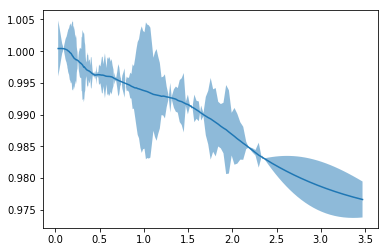

In [38]:
# par = [0.136512329, 0.971, 0.82, 1e-06, 1]
# 11, 17, 20, 37, 46
# params = np.loadtxt(paramIn)

# ctx_for_loading = gpflow.saver.SaverContext(autocompile=False)
# saver = gpflow.saver.Saver()

# m1 = saver.load(GPmodel, context=ctx_for_loading)
# m1.clear()
# m1.compile()

# pca_model = pickle.load(open(PCAmodel, 'rb'))



params = np.loadtxt(paramIn)
params.min()
par = params[46]
# par = [1.46428570e-01, 9.56122398e-01, 8.14285755e-01, 2.05061588e-06, 8.16328004e-02] #params[11]
par = [0.14, 1.0, 0.7, 1e-6, 1.0] #params[11]

scaled_par = scale01(lhdmin, lhdmax, par)
print(par)
print( (scaled_par))

# x_id = 46
# 
# 

# print( params[np.argmin(params[:,3])])
# print(parameter_array_all[x_id])
plt.figure(12)
# print(Emu(scaled_par))
# print( unscalePk(Emu(scaled_par), ydiv, ysub) )

# plt.plot(kvals, Emu(scaled_par))
# plt.plot(kvals, unscalePk( EmuPlusMinus(scaled_par)[0],  ydiv, ysub) )
# plt.fill_between(kvals, unscalePk( EmuPlusMinus(scaled_par)[1], ydiv, ysub), unscalePk(EmuPlusMinus(scaled_par)[2], ydiv, ysub), alpha = 0.5)

plt.plot(kvals, 10**( EmuPlusMinus(scaled_par)[0]) )
plt.fill_between(kvals, 10**( EmuPlusMinus(scaled_par)[1]), 10**(EmuPlusMinus(scaled_par)[2]), alpha = 0.5)

# plt.plot(kvals, np.ones_like(kvals), 'k--')
plt.show()

In [39]:
# print(ysub, ydiv)

In [40]:
 10**( EmuPlusMinus(scaled_par)[0]).min()

0.9765927167652924